In [1]:
import sys
import os
import numpy as np
import scipy.sparse.linalg as spla
import torch
from torch import _linalg_utils as _utils, Tensor
import tensorly as tl
tl.set_backend('pytorch')

# Add the project root directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected. Check your CUDA installation.")

No GPU detected. Check your CUDA installation.


In [3]:
from sensor_placement.utils  import Tensorization, Matrixization, extract_subtensor, compute_info_gain, load_tensor, matrixize_numpy_array, plot_histogram, solve_subtensor_system, plot_histogram_relError
from sensor_placement.decomposition import  TuckerOEDSelection, ScketchThenTuckerOEDSelection
from sensor_placement.tests import run_oed_methods, benchmark_oed_methods
#from sensor_placement.utils import get_tensor_shape, get_tensor_size, get_tensor_rank, get_tensor_mode_size, get_tensor_mode_shape 

In [4]:
A = load_tensor("Ah.npy", sub_folder="seismic")  # same as A = Matrixization(X) 
Xpy = load_tensor("Aht.npy",sub_folder="seismic") # X = Tensorization(A,shape= X.shape)
# XXX = Tensorization(A,shape= (32, 45, 4096))
# torch.norm(XXX - Xpy)
print("shape A", A.shape)
print("Shape tensorized A", Xpy.shape)

File was found inside the subfolder inside 'data'. 
File was found inside the subfolder inside 'data'. 
shape A (4096, 1440)
Shape tensorized A (32, 45, 4096)


In [5]:
EIG_full = compute_info_gain(A)
print("Full EIG (all sensors)",EIG_full) 

Full EIG (all sensors) 111.1804122044516


In [6]:
ns,nr,npts = Xpy.shape
print(f"# sources: {ns}, # receivers: {nr}, # points: {npts}")

# sources: 32, # receivers: 45, # points: 4096


In [7]:
k = 10
#Number of target sensors 
k1 = k
k2 = k
Pi = np.arange(Xpy.ndim-1) # processing order (0,1,2,...) change according to problem.  (last dimension avoided)
target_rank = (k1, k2) # , X.shape[-1]
K = np.prod(target_rank)

In [8]:
X = tl.tensor(Xpy).clone() 

In [9]:
# Random Designs 
nsamples = 500
OED_values = np.zeros(nsamples)  # Initialize an array of zeros
s, p = ns, nr

for rr in range(nsamples):  # Loop over the range 1 to 100  
    S_listR = []
    ir1 = np.random.choice(s, size=k1, replace=False)# np.random.permutation(s)[:k1]  # Random permutation of range(s), take the first k elements
    ir2 = np.random.choice(p, size=k2, replace=False) #np.random.permutation(p)[:k2]  # Random permutation of range(p), take the first k elements
    S_listR.append(ir1)
    S_listR.append(ir2)
    subtensor =  extract_subtensor(X, S_listR, Pi)
    unfolded =  Matrixization(subtensor)
    OED_values[rr] = compute_info_gain(unfolded)

In [10]:
flagSketchA = False
if flagSketchA:
    p = 10 # oversampling 
    n =  A.shape[0]
    K = np.prod(target_rank)
    d2 = K + p
    mu, sigma = 0, 1/np.sqrt(d2)
    sketchA = np.random.normal(mu, sigma, (d2, n)) @ A
    EIG_sketch = compute_info_gain(sketchA)
    print("Sketch EIG (all sensors)", EIG_sketch) 
    shape_sketchX  = list(X.shape) 
    shape_sketchX[-1] = d2
    sketchX = Tensorization(sketchA ,shape= shape_sketchX) 
    print("Tensor Shape X", X.shape)
    print("Tensor Shape after sketch", sketchX.shape)
    X1 = tl.tensor(sketchX)
else:
    X1 = tl.tensor(X)
    print("Tensor Shape X", X.shape)

Tensor Shape X torch.Size([32, 45, 4096])


Method: IndSelect
Selected Indices for mode: 0
[ 0 31 28  3 21 14 24  7 17 10]
Selected Indices for mode: 1
[ 0 44 17  4 21 13  9 38 33 27]
EIG: 31.022334795335517
Method: SeqSelect
Selected Indices for mode: 0
[ 0 31 28  3 21 14 24  7 17 10]
Selected Indices for mode: 1
[ 0 44 17  4 21 13  9 38 33 27]
EIG: 31.022334795335517
Method: IterSelect
Selected Indices for mode: 0
[ 0 31 28  3 17 10 24  7 14 21]
Selected Indices for mode: 1
[ 0 44 17  4 21 13  9 38 33 27]
EIG: 31.022334795335517


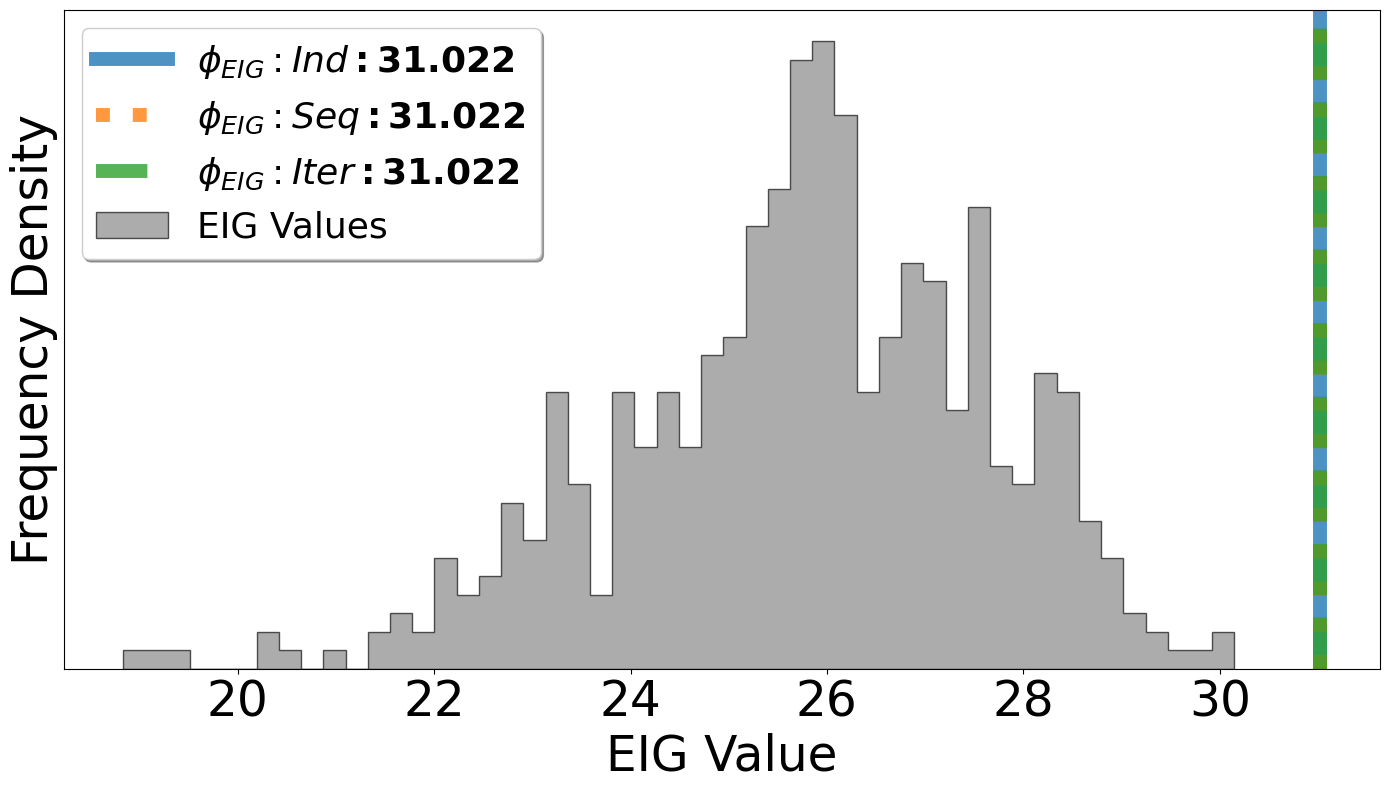

In [11]:
methods =  ["IndSelect", "SeqSelect", "IterSelect"]

# Run the function
indices_dict = run_oed_methods(
    X=X,
    X1=X1,
    target_rank=target_rank,
    Pi=Pi,
    methods=methods,
    plot=True,  # Set to True if you want to plot the results
    OED_values=OED_values,
    k=k,
    bins=nsamples//10,#'auto',
    Scientificnot= False,
    decimal_places=3,
    loc= 'upper left',
    show_title=False,
    greedy_approach= False
)

In [12]:
timesSelec =benchmark_oed_methods(X1, target_rank=target_rank, Pi=Pi, methods=["IndSelect", "SeqSelect", "IterSelect"], greedy_approach=False, n_runs=10)

Avg time for IndSelect: 0.9534 seconds
Avg time for SeqSelect: 0.4385 seconds
Avg time for IterSelect: 0.5201 seconds


#   Sketch-First approach  

In [13]:
Slist = ScketchThenTuckerOEDSelection(A, p=10, target_rank=target_rank, method ="IterSelect", shapeX= X.shape, Pi =Pi, n_iter_max=10 )

In [14]:
subtensor =  extract_subtensor(X, Slist, Pi)
unfolded =  Matrixization(subtensor)
EIG = compute_info_gain(unfolded)
print(EIG)

31.09355419959607


# Posterior mean Reconstruction (MAP-Estimate)

In [15]:
fact = 1e-2
sigma2 = 0.4373 # noise level 

In [16]:
K = load_tensor("K.npz", sub_folder="seismic", sparse=True)   # \kappa^2 I - \Delta 
M = load_tensor("M.npz",sub_folder="seismic", sparse=True)    # Mass matrix
F = load_tensor("F.npz",sub_folder="seismic", sparse=True)   # Forward operator 
print("shape K", K.shape)
print("Shape M", M.shape)
print("Shape F", F.shape)

File was found inside the subfolder inside 'data'. 
File was found inside the subfolder inside 'data'. 
File was found inside the subfolder inside 'data'. 
shape K (4096, 4096)
Shape M (4096, 4096)
Shape F (1440, 4096)


In [17]:
xt = load_tensor("xt.npy", sub_folder="seismic")    # True Sol
xt = xt.ravel()
d = load_tensor("d.npy",sub_folder="seismic")       # data 
d = d.ravel()
bn = load_tensor("bn.npy",sub_folder="seismic")     # corrupted data 
bn = bn.ravel()
print("shape xt", xt.shape)
print("Shape d", d.shape)
print("Shape bn", bn.shape)

File was found inside the subfolder inside 'data'. 
File was found inside the subfolder inside 'data'. 
File was found inside the subfolder inside 'data'. 
shape xt (4096,)
Shape d (1440,)
Shape bn (1440,)


In [18]:
Ft = load_tensor("Ft.npy", sub_folder="seismic")    
btt = load_tensor("btt.npy",sub_folder="seismic")    
print("shape Ft", Ft.shape)
print("Shape btt", btt.shape)

File was found inside the subfolder inside 'data'. 
File was found inside the subfolder inside 'data'. 
shape Ft (32, 45, 4096)
Shape btt (32, 45)


# Prior as preconditioner 

In [19]:
Mx = spla.LinearOperator(K.shape, lambda x: spla.spsolve(K, M @ spla.spsolve(K, x)) / fact, dtype=K.dtype)

In [20]:
def Av(v):
    return (F.T @ (F @ v)) / sigma2 + (fact / sigma2) * (K @ spla.spsolve(M, K @ v))

In [21]:
# linear operator for the system
A = spla.LinearOperator(
    M.shape, 
    matvec=Av, 
    dtype=M.dtype
)

In [22]:
# Right-hand side
b = (F.T @ bn) / sigma2
b = b.ravel()

In [23]:
# Solve using conjugate gradient
xf, flag = spla.cg(A, b, rtol=1e-6, maxiter=300, M=Mx) 

In [24]:
# Ensure that the CG method converged successfully
assert flag == 0, f"CG did not converge. Number of iterations = {flag}"

In [25]:
rerr_full = np.linalg.norm(xf - xt) / np.linalg.norm(xt)
print(rerr_full)

0.09376809020260933


In [26]:
S_list = TuckerOEDSelection(X, core_size=target_rank, method="IndSelect" , Pi=Pi) # "IterSelect"

In [27]:
subtensor =  extract_subtensor(X, S_list, Pi)
unfolded =  Matrixization(subtensor)
EIG = compute_info_gain(unfolded)
print(EIG)

31.022334795335517


In [28]:
_, rerr = solve_subtensor_system(
    Ft, btt, S_list, Pi, sigma2, fact, K, M, target_rank, Mx, xt, maxiter=300, rtol=1e-6
)
print( "Relative error IndSelect", rerr )

Relative error IndSelect 0.11514486775099901


In [29]:
REHOSVD   =  rerr
RelErrFull = rerr_full

In [30]:
mpostErrors = False# Takes a lot of time (not optimized) 

if mpostErrors:    
    # Random Designs 
    nsamples = 3000 # nsamples
    RelMpostErrors = np.zeros(nsamples)  # Initialize an array of zeros
    s, p = ns, nr

    for rr in range(nsamples):  # Loop over the range 1 to 100  
        S_listRe = []
        ir1 = np.random.choice(np.arange(s), size=k1, replace=False)  # Random permutation of range(s) 
        ir2 = np.random.choice(np.arange(p), size=k2, replace=False)  # Random permutation of range(p) 
        S_listRe.append(ir1)
        S_listRe.append(ir2)

        Fs = extract_subtensor(Ft, S_listRe, Pi)
        Fs = matrixize_numpy_array(Fs).T  # same asFs = Matrixization(tl.tensor(Fs).clone() ).T

        bs = extract_subtensor(btt, S_listRe, Pi)
        bs = np.reshape(bs, ( np.prod(target_rank), 1), order='C')

        def Asv(v):
            return (Fs.T @ (Fs @ v)) / sigma2 + (fact / sigma2) * (K @ spla.spsolve(M, K @ v))

        # linear operator for the system
        AS = spla.LinearOperator(
            M.shape, 
            matvec=Asv, 
            dtype=M.dtype
        )

        Sb = (Fs.T @ bs) / sigma2
        Sb = Sb.ravel()

        # Solve using conjugate gradient
        xs, flag = spla.cg(AS, Sb, rtol=1e-8, maxiter=300, M=Mx) 

        rerr_full = np.linalg.norm(xs - xt) / np.linalg.norm(xt)
        #print(rerr_full)
        RelMpostErrors[rr] = rerr_full
    np.save("RelMpostErrorsSei.npy",  RelMpostErrors)    

In [31]:
#RelMpostErrors = np.load("RelMpostErrorsSei.npy")
RelMpostErrors =load_tensor("RelMpostErrorsSei.npy", sub_folder="seismic") 

File was found inside the subfolder inside 'data'. 


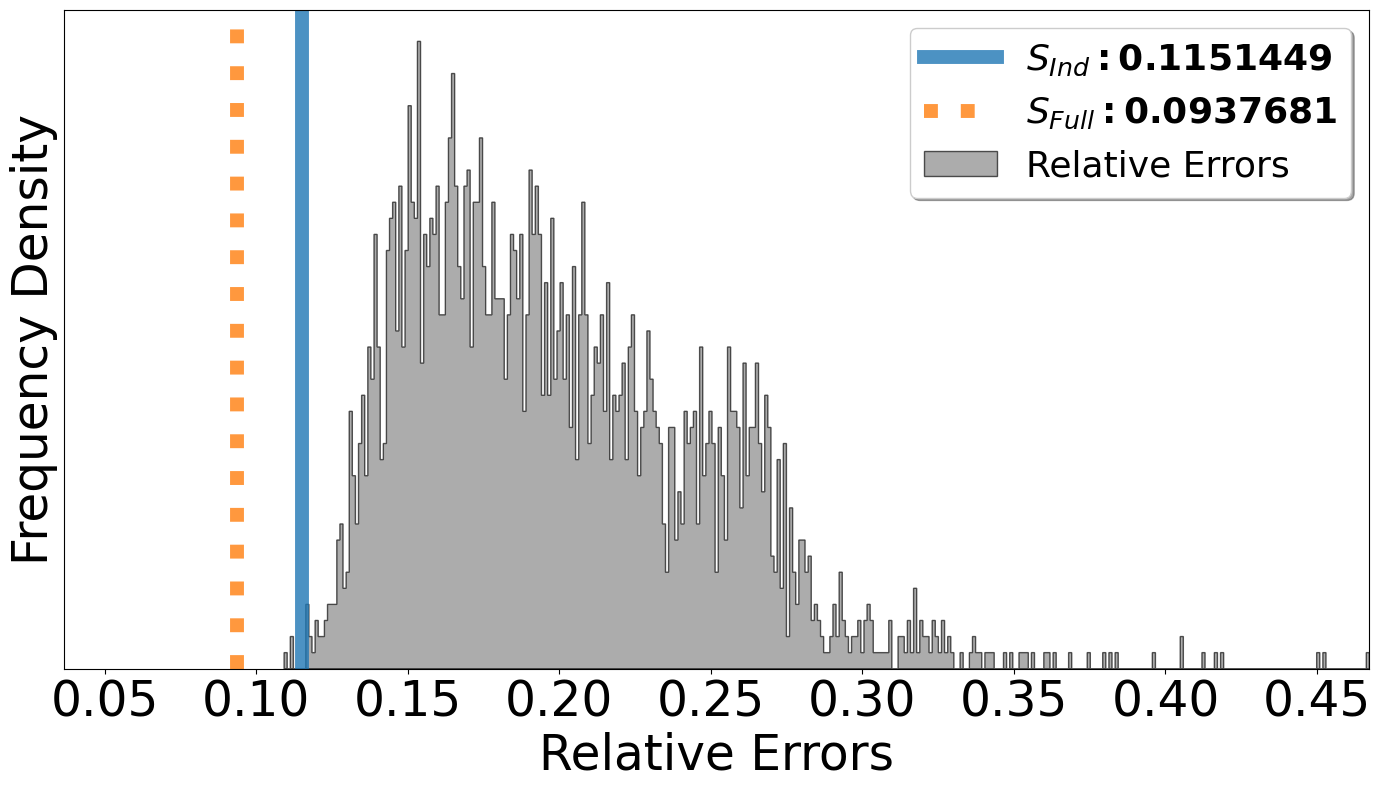

In [32]:
indices_dict = {
    '{S}_{Ind}': REHOSVD,  # Example indices
    #  '{S}_{Seq}': RESTHOSVD,
    #  '{S}_{Iter}': REHOOI,
     '{S}_{Full}': RelErrFull
}

plot_histogram_relError(indices_dict, RelMpostErrors, k=k, bins=350, decimal_places=7,show_title=False,  loc= 'upper right',fontsize=35)